# Adaptive Cruise Control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.11.5 (main, Aug 25 2023, 13:19:53) [GCC 9.4.0]'

In [3]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import os

## Setup Problem (dynamics, environment and CBF)

Dynamics of the Adaptive Cruise Control problem (control affine), in the format of `cbf_opt`

`ACC_JNP_Dynamics` is required for usage with `hj_reachability` module

In [4]:
class ACCDynamics(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1 / self.mass 
        return B


class ACCJNPDynamics(ACCDynamics):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

Setting up the Dynamics with specific parameter instantiation

In [5]:
params = dict()
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACCDynamics(params)
acc_jnp = ACCJNPDynamics(params)

## Initial Control Barrier Function
Below is a candidate CBF (safe, but overly conservative) for the problem. This is the optimal CBF when neglecting friction (but it does account for limited actuation).

In [6]:
class ACCCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.Th = params["Th"]
        self.cd = params["cd"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

Setting up the CBF with specific parameter instantiation

In [7]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACCCBF(acc, cbf_params)
acc_jnp_cbf = ACCCBF(acc_jnp, cbf_params)

Setting maximal and minimal control effort

In [8]:
umax = np.array([cbf_params['cd'] * params['mass'] * params['g']])
umin = -umax

### Environment

In [9]:
dyn_reachability_jnp = refine_cbfs.HJControlAffineDynamics(acc_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))
dyn_reachability = refine_cbfs.HJControlAffineDynamics(acc, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([1e3, 40., 100.])
nbr_pts = (51, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)
grid_np = refine_cbfs.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

In [10]:
obstacle = grid.states[..., 2] - acc_cbf.Th * grid.states[..., 1]

## Refining the CBF using Dynamic Programming

In [11]:
acc_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc, dict(), grid=grid)
acc_jnp_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc_jnp, dict(), grid=grid)

acc_tabular_cbf.tabularize_cbf(acc_cbf)
acc_jnp_tabular_cbf.tabularize_cbf(acc_jnp_cbf)

In [12]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))
init_value = acc_jnp_tabular_cbf.vf_table

In [13]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values_hjr = hj.solve(solver_settings, dyn_reachability_jnp, grid, times, obstacle)

100%|##########################################################| 20.0000/20.0 [00:01<00:00, 16.70sim_s/s]


In [14]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability_jnp, grid, times, init_value)

100%|##########################################################| 20.0000/20.0 [00:01<00:00, 16.71sim_s/s]


Turning the converged value function into a CBVF that interfaces with `cbf_opt`

In [15]:
refined_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(acc_jnp, grid=grid)

refined_cbf.vf_table = np.array(target_values[-1])
refined_cbf_jnp.vf_table = target_values[-1]

Saving the partially converged CBF to highlight the importance of refining from a conservative solution

In [16]:
timestamp = 2
partial_hjr_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
partial_hjr_cbf.vf_table = np.array(target_values_hjr[timestamp])

partial_refined_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
partial_refined_cbf.vf_table = np.array(target_values[timestamp])

## Running an experiment (Same as the Paper)

In [17]:
x0 = np.array([[0, 25, 90]])
n_sims_per_start = 1
t_sim = 20

In [18]:
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment

### Setting up the nominal controller

We simply tune a proporitional controller for the nominal controller

In [19]:
desired_vel = 24
feedback_gain = 200
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-feedback_gain * (x[..., 1] - desired_vel), umin, umax))
nominal_policy_jnp = lambda x, t: jnp.atleast_1d(jnp.clip(-feedback_gain * (x[..., 1] - desired_vel), umin, umax))

### Setting up the safety filter

In [20]:
alpha = lambda x: 5 * x

acc_asif = ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)
acc_asif_ws = ControlAffineASIF(acc, refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)

acc_partial_hjr_asif = ControlAffineASIF(acc, partial_hjr_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)
acc_partial_asif_ws = ControlAffineASIF(acc, partial_refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)

# Visualizations for paper + demo + videos

In [21]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': False,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as anim

### Safe set visualization

In [22]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

In [23]:
colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
colors = np.array(colors)

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [24]:
toggle_hjr_visualization = False
save_video = False
video_file_name = "acc.mp4"

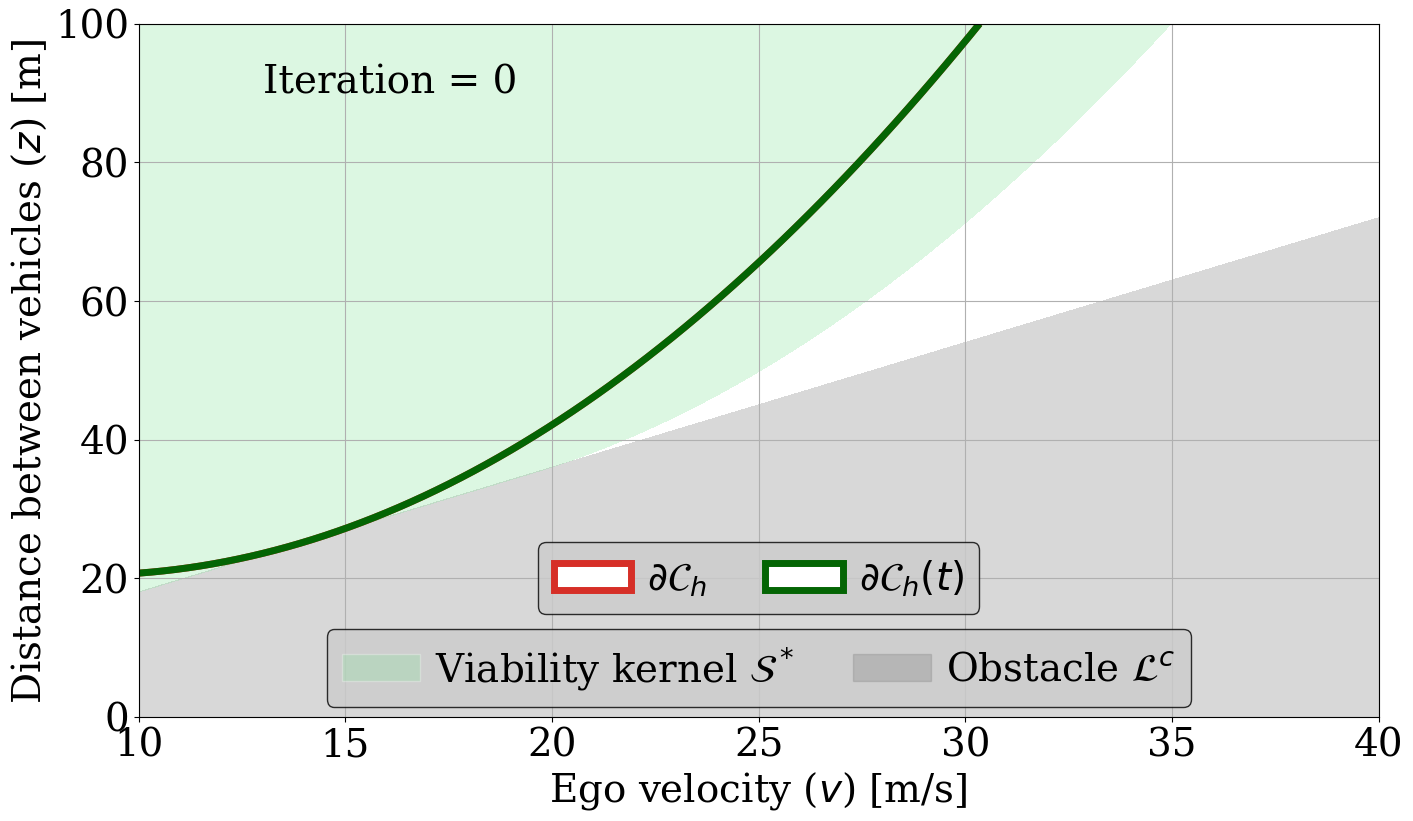

In [25]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[i][0].T, levels=[0], 
                      colors=np.array([colors[-1]]))

    if toggle_hjr_visualization:
        global cont2
        for c in cont2.collections:
            c.remove()
        cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hjr[i][0].T, levels=[0],
                           colors=np.array([chosen_colors[0]]))
    

proxy = [] 

fig, ax = plt.subplots(figsize=(16, 9))

obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle[0].T, levels=[-100, 0], 
                 colors='grey', alpha=0.3)


cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[-1][0].T, levels=[0, 200], 
                 colors=alt_colors[2], alpha=0.3)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[0][0].T, levels=[0], 
                  colors=np.array([colors[3]]))   # Initial CBF
proxy += [plt.Rectangle((0,0),1,1,ec =colors[3], fc='white', lw=5)
        for pc in cont.collections]

proxy += [plt.Rectangle((0,0),1,1,ec =colors[-1], fc='white', lw=5) for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[0][0].T, levels=[0], 
                  colors=np.array([colors[-1]]))

ax.grid()
proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
leg = ax.legend(proxy, legend_entries,
          loc='center', bbox_to_anchor=(0.5, 0.2), ncol=3, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')
ax.legend(proxy2, ["Viability kernel $\mathcal{S}^*$", "Obstacle $\mathcal{L}^c$"],
          loc='center', bbox_to_anchor=(0.5, 0.07), ncol=3, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')
ax.add_artist(leg)
ax.set_ylabel("Distance between vehicles ($z$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 6 // 20, interval=100)
if save_video:
    animation.save(video_file_name, writer='ffmpeg')

### Online: Safety filter visualization

In [26]:
x0 = np.array([0, 30, 90])
experiment_paper = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [27]:
paper_results = experiment_paper.run(acc, {'nominal': nominal_policy, 'Analytical': acc_asif, 'Refined': acc_asif_ws, 'partial_hjr': acc_partial_hjr_asif, 'partial_cbf': acc_partial_asif_ws})

Controller rollout:   0%|                                                       | 0/2000 [00:00<?, ?it/s]QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning s

In [28]:
save_figure = False
figure_file_name = "acc.png"

IndexError: index 2000 is out of bounds for axis 0 with size 2000

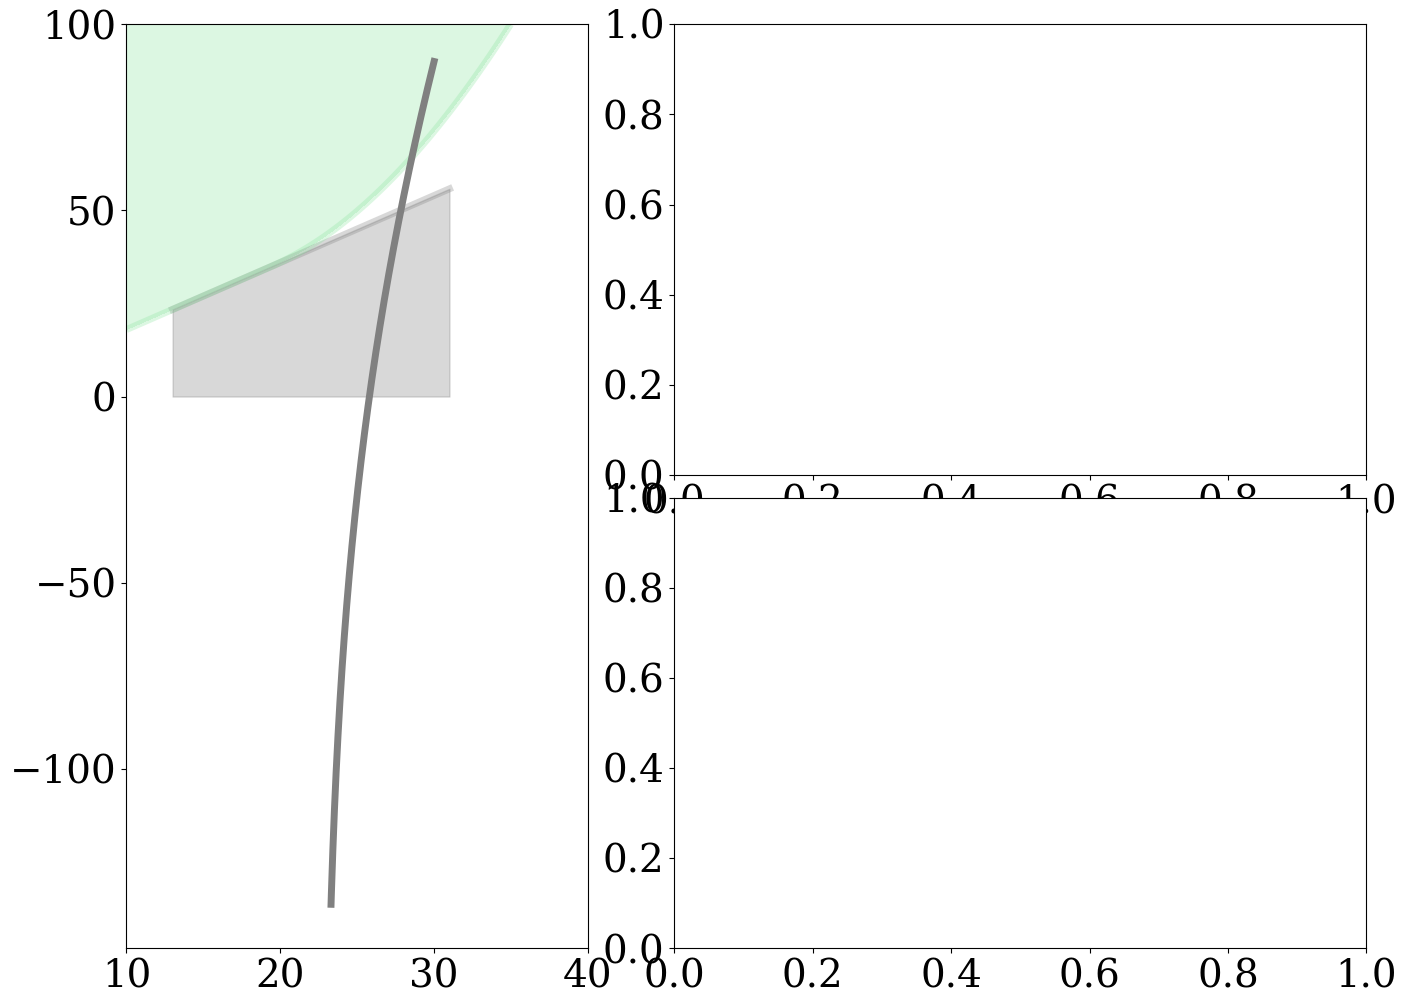

In [29]:
ts_experiment_addt = TimeSeriesExperiment('acc_example', x_indices=[], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment_addt = StateSpaceExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

# fig, axs = plt.subplots(3, 1, sharex=False, figsize=(16, 12))
alt_colors = sns.color_palette("pastel", 9).as_hex()
# plt.subplots_adjust(hspace=0.0)
#make outer gridspec
fig = plt.figure(figsize=(16, 12))
colors = sns.color_palette("tab10")
outer = gridspec.GridSpec(1, 2, width_ratios= [2, 3], figure=fig, wspace=.15) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .05)
axs = []
for cell in gs1:
    axs += [plt.subplot(cell)]

for cell in gs2:
    axs += [plt.subplot(cell)]
    
axs = np.array(axs)
x = np.linspace(13, 31, 1000)
axs[0].fill_between(x, acc_cbf.Th * x, alpha=0.3, color='grey')
axs[0].plot(x, acc_cbf.Th * x, color='grey', alpha=.3)

axs[0].contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[-1][0].T, levels=[0, 200], 
                alpha=0.3, colors=alt_colors[2])
axs[0].contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[-1][0].T, levels=[0], 
               colors=alt_colors[2], alpha=.3)

fig_handle_ss = ss_experiment_addt.plot(acc, paper_results, extra_measurements=['vf'], ax=axs[0], 
                                        color=chosen_colors, linestyles=['-', '-', '-', '--', '--'])
fig_handle_ts = ts_experiment_addt.plot(acc, paper_results, extra_measurements=['vf'], axs=axs[1:], 
                                        colors=chosen_colors, linestyles=['-', '-', '-', '--', '--'])

plt.rcParams["font.family"] = "serif"
axs[1].get_shared_x_axes().join(axs[1], axs[2])
axs[0].set_xlabel("Ego velocity [m/s]")
axs[0].set_ylabel("Distance between cars [m]")
for ax in axs:
    for line in ax.lines:
        line.set_linewidth(3.5)

ts = axs[1].lines[0]._x

axs[1].set_ylabel("Control [m/s$^2$]")

axs[1].set_xticklabels([])

axs[0].set_ylim([0, 100])
axs[0].set_xlim([13, 31])

leg = axs[1].legend(["Nominal", "Initial CBF", "Converged CBVF", "Partial HJR", "Partial CBF"], ncol=5, loc='center', bbox_to_anchor=(0.1, -1.3))    
axs[1].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
axs[1].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, .9))

axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].set_ylabel("CBF value")
axs[2].set_xlabel("Time")


axs[1].add_artist(leg)
axs[2].set_xticks(np.arange(0,11))
axs[1].set_xticks(np.arange(0,11))
for ax in axs:
    ax.grid(which='both')
for ax in axs[1:]:
    ax.set_xlim(ts[0], 10)

if save_figure:
    fig.savefig(figure_file_name, dpi=400, bbox_inches='tight')